# 等角正轴投影变换
##### 李东航  北京大学城市与环境学院

### 1 引入Python库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

### 2 设置地图范围

In [2]:
#地图比例尺
scale=1/4000000
#制图区域范围
lat_s=math.radians(35)
lat_n=math.radians(43)
lon_w=math.radians(113)
lon_e=math.radians(120)
# 经纬网密度
dtlat=1
dtlon=1
#输入经纬度范围
Lon=np.arange(113,121,dtlon)
Lat=np.arange(35,44,dtlat)

### 3 设置画布大小

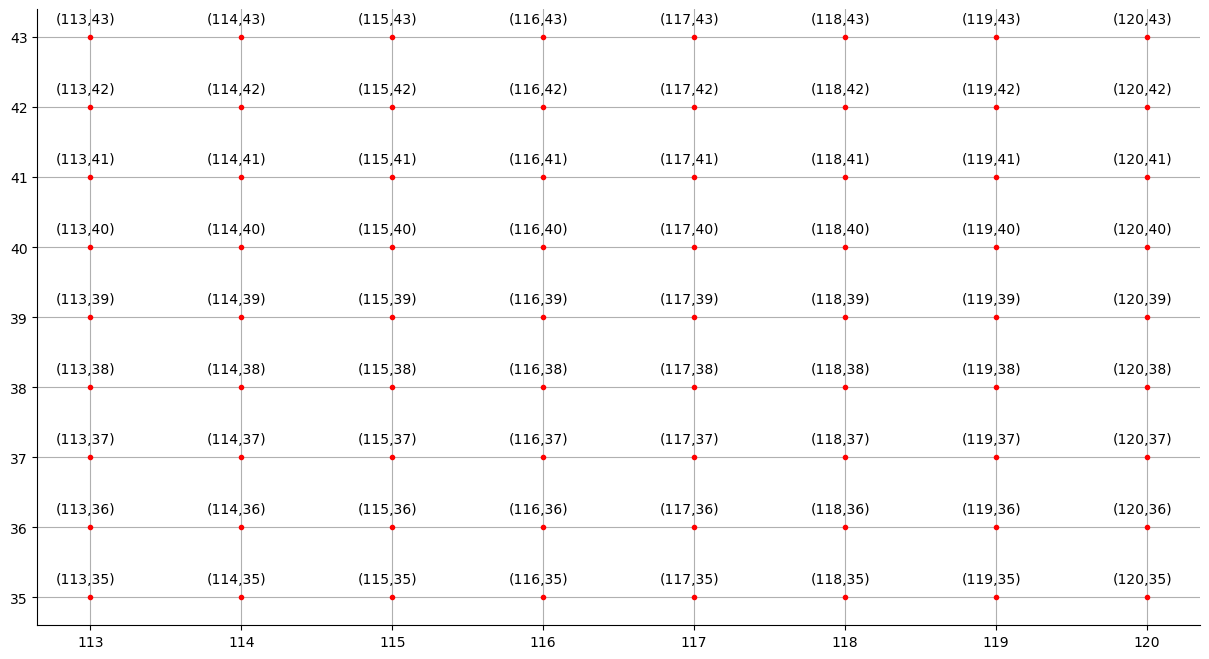

In [3]:
plt.figure(figsize=(15,8))
for i in Lon:
    for j in Lat:
        plt.annotate("(%s,%s)" % (i,j), xy=(i,j), xytext=(-25, 10), textcoords='offset points')
X,Y=np.meshgrid(Lon,Lat)
plt.plot(X,Y,color='red',marker='.', linestyle='')
plt.grid(True)
sns.despine()
plt.show()

### 4 圆柱投影变换

In [4]:
def MercatorProjection(lon,lat):
    #墨卡托投影 
    # 输入：经度lon，纬度lat  
    # 输出：投影后的经度x，投影后的纬度y
    lon=math.radians(lon) #转换为弧度
    lat=math.radians(lat) 
    x = lon
    y = math.log(math.tan((math.pi*0.25) + (0.5 * lat )))
    return x,y

In [11]:
#进行投影变换
output0=pd.DataFrame()
output_x0=pd.DataFrame()
output_y0=pd.DataFrame()
points0=pd.DataFrame()

# 保存投影变换后的点
res_x0=[]
res_y0=[]
for i in range(len(Lon)):
    for j in range(len(Lat)):
        X,Y=MercatorProjection(Lon[i],Lat[j])
        output0.loc[Lat[j],Lon[i]]='('+str(X)+','+str(Y)+')'
        output_x0.loc[Lat[j],Lon[i]]=X
        output_y0.loc[Lat[j],Lon[i]]=Y
        res_x0.append(X)
        res_y0.append(Y)
for i in range(len(res_x0)):
    points0.loc[i,0]=res_x0[i]
    points0.loc[i,1]=res_y0[i]
points0.to_csv('points0.csv',sep=',')
output0.to_csv('output0.csv',sep=',') 
output_x0.to_csv('output_x0.csv',sep=',')
output_y0.to_csv('output_y0.csv',sep=',')

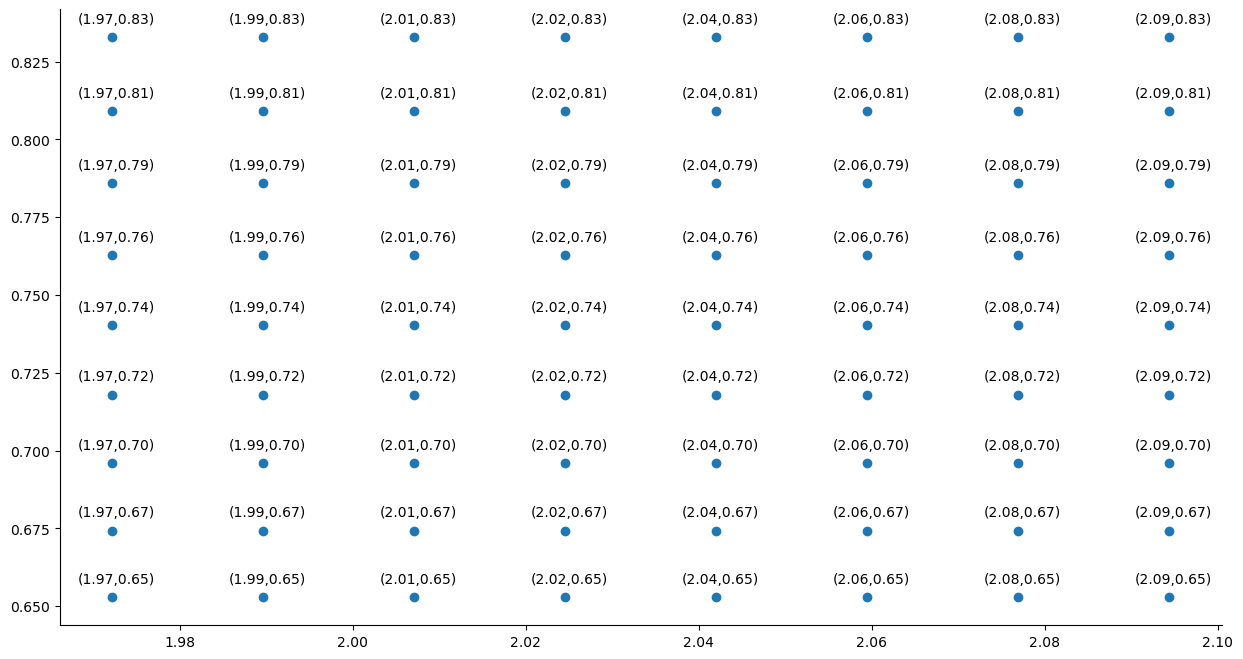

In [12]:
#绘图
#设置画布大小
plt.figure(figsize=(15,8))
#散点图
plt.scatter(res_x0,res_y0)
#坐标显示
for xy in zip(res_x0,res_y0):
     plt.annotate("(%.2f,%.2f)" % xy, xy=xy, xytext=(-25, 10), textcoords='offset points')
sns.despine()
plt.show()

### 5 圆锥投影变换

##### 1 正轴等角切圆锥投影

##### 1.1 变量计算

In [4]:
# 计算ar
clon = math.radians(116.5) #将中央经线转换为弧度
slat = math.radians(39)  # 将标准纬线转换为弧度
ar = math.sin(slat)
ar

0.6293203910498374

In [5]:
# 2000年国家大地坐标系的地球椭球参数
a = 6378137
e = 0.0818191910428

# 计算纬圈半径r0
r0 = a * math.cos(slat) / math.sqrt(1 - (e**2) * (math.sin(slat)**2))
r0*100

496332733.86349344

In [6]:
# 计算不同纬度对应的r
for i in range(35,44):
    lat = math.radians(i)
    r = a * math.cos(lat) / math.sqrt(1 - (e**2) * (math.sin(lat)**2))
    print(r*100)

523042684.02286035
516599877.7539878
509999311.74345386
503242932.1560123
496332733.86349344
489270760.01058936
482059101.5622306
474699896.8322166
467195330.9927922


In [7]:
# 计算k
par0 = math.asin(e * math.sin(slat))
U0 = math.tan((math.pi * 0.25) + (slat * 0.5)) * (math.tan((math.pi * 0.25) + (par0 * 0.5))**(-e))
k = r0 * (U0**ar) / ar
k*100

1253365171.7945213

In [8]:
# 计算最低纬圈投影半径lengths
pars = math.asin(e * math.sin(lat_s))
Us = math.tan((math.pi * 0.25) + (lat_s * 0.5)) * (math.tan((math.pi * 0.25) + (pars * 0.5))**(-e))
lengths = k / (Us**ar)
lengths*100

833107079.6580606

In [9]:
# 计算不同纬度对应的U
for i in range(35,44):
    lat = math.radians(i)
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))
    print(U*100)
    

191.36147993010906
195.4897147304411
199.76189703431018
204.1863833049864
208.7721843784879
213.5290309051042
218.46744680395207
223.59883189914035
228.93555510502148


In [10]:
# 计算不同纬度对应的rou
for i in range(35,44):
    lat = math.radians(i)
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))
    rou = k / (U**ar)
    print(rou*100)

833107079.6580606
821991653.5679573
810884281.1256704
799781676.8317647
788680520.9592956
777577452.9201146
766469064.2580343
755351891.217309
744222406.8286903


##### 1.2 投影变换函数

In [11]:
#投影变换函数
def ConicProjection1(lon, lat, clon, slat):
    # 正轴等角切圆锥投影 
    # 输入：经度lon，纬度lat，中央经线clon，标准纬线slat
    # 输出：投影后的 x, y 坐标
    
    lon = math.radians(lon)  # 将经度转换为弧度
    lat = math.radians(lat)  # 将纬度转换为弧度
    clon = math.radians(clon) #将中央经线转换为弧度
    slat = math.radians(slat)  # 将标准纬线转换为弧度
    
    # 计算投影
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))
    
    # 极坐标公式
    length = k / (U**ar)
    angle = ar * (lon - clon) 
    
    # 直角坐标系公式
    y = (lengths - length * math.cos(angle)) / 40000
    x = length * math.sin(angle) / 40000
    
    return x, y

In [12]:
#进行投影变换
output1=pd.DataFrame()
output_x1=pd.DataFrame()
output_y1=pd.DataFrame()
points1=pd.DataFrame()

# 保存投影变换后的点
res_x1=[]
res_y1=[]
for i in range(len(Lon)):
    for j in range(len(Lat)):
        X,Y=ConicProjection1(Lon[i],Lat[j],116.5,39)
        output1.loc[Lat[j],Lon[i]]='('+str(X)+','+str(Y)+')'
        output_x1.loc[Lat[j],Lon[i]]=X
        output_y1.loc[Lat[j],Lon[i]]=Y
        res_x1.append(X)
        res_y1.append(Y)
for i in range(len(res_x1)):
    points1.loc[i,0]=res_x1[i]
    points1.loc[i,1]=res_y1[i]
points1.to_csv('points1.csv',sep=',')
output1.to_csv('output1.csv',sep=',') 
output_x1.to_csv('output_x1.csv',sep=',')
output_y1.to_csv('output_y1.csv',sep=',')

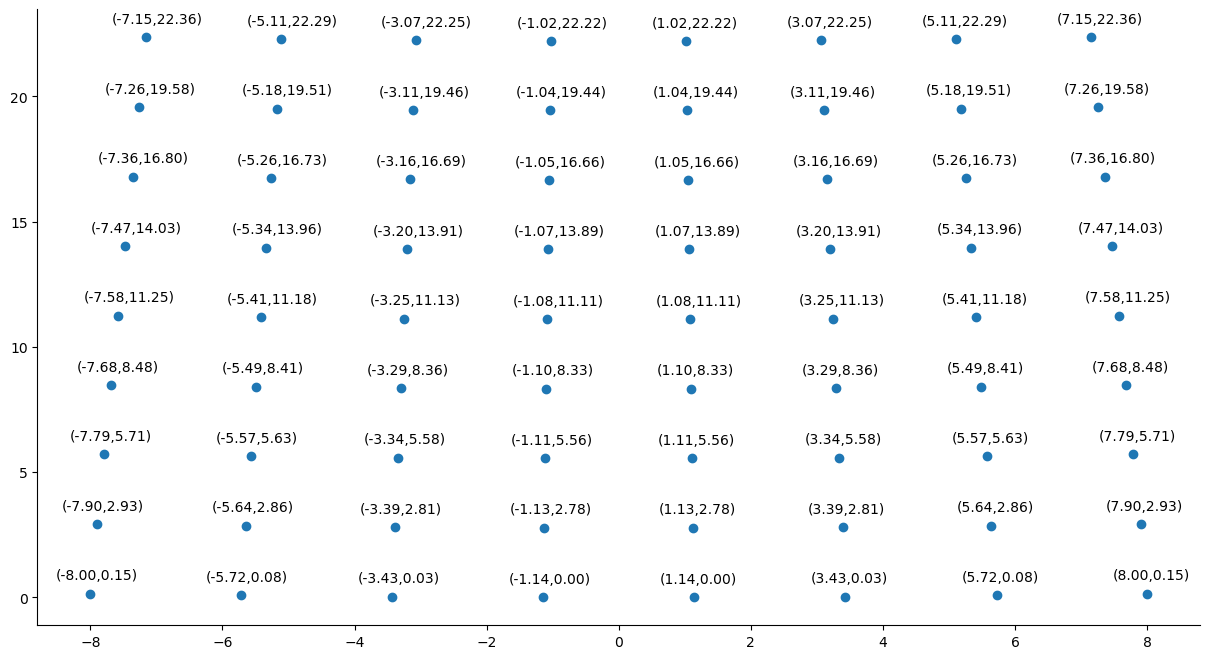

In [13]:
#绘图
#设置画布大小
plt.figure(figsize=(15,8))
#散点图
plt.scatter(res_x1,res_y1)
#坐标显示
for xy in zip(res_x1,res_y1):
     plt.annotate("(%.2f,%.2f)" % xy, xy=xy, xytext=(-25, 10), textcoords='offset points')
sns.despine()
plt.show()

##### 2 正轴等角割圆锥投影

##### 2.1 变量计算

In [14]:
# 计算ar
clon = math.radians(116.5) #将中央经线转换为弧度
slat1 = math.radians(38)  # 将标准纬线转换为弧度
slat2 = math.radians(40)
r1 = a * math.cos(slat1) / math.sqrt(1 - e**2 * math.sin(slat1)**2) #计算纬圈半径
r2 = a * math.cos(slat2) / math.sqrt(1 - e**2 * math.sin(slat2)**2)
par1 = math.asin(e * math.sin(slat1))
par2 = math.asin(e * math.sin(slat2))
U1 = math.tan((math.pi * 0.25) + (slat1 * 0.5)) * (math.tan((math.pi * 0.25) + (par1 * 0.5))**(-e))
U2 = math.tan((math.pi * 0.25) + (slat2 * 0.5)) * (math.tan((math.pi * 0.25) + (par2 * 0.5))**(-e))
ar = (math.log(r2)-math.log(r1))/(math.log(U1)-math.log(U2))
ar

0.6293528648227491

In [15]:
# 2000年国家大地坐标系的地球椭球参数
a = 6378137
e = 0.0818191910428

# 计算纬圈半径r0
r0 = a * math.cos(slat) / math.sqrt(1 - (e**2) * (math.sin(slat)**2))
r0*100

496332733.86349344

In [16]:
# 计算不同纬度对应的r
for i in range(35,44):
    lat = math.radians(i)
    r = a * math.cos(lat) / math.sqrt(1 - (e**2) * (math.sin(lat)**2))
    print(r*100)

523042684.02286035
516599877.7539878
509999311.74345386
503242932.1560123
496332733.86349344
489270760.01058936
482059101.5622306
474699896.8322166
467195330.9927922


In [17]:
# 计算k
k = r1 * (U1**ar) / ar
k*100

1253140340.263591

In [18]:
# 计算最低纬圈投影半径lengths
pars = math.asin(e * math.sin(lat_s))
Us = math.tan((math.pi * 0.25) + (lat_s * 0.5)) * (math.tan((math.pi * 0.25) + (pars * 0.5))**(-e))
lengths = k / (Us**ar)
lengths*100

832940080.3574762

In [19]:
# 计算不同纬度对应的U
for i in range(35,44):
    lat = math.radians(i)
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))
    print(U*100)

191.36147993010906
195.4897147304411
199.76189703431018
204.1863833049864
208.7721843784879
213.5290309051042
218.46744680395207
223.59883189914035
228.93555510502148


In [20]:
# 计算不同纬度对应的rou
for i in range(35,44):
    lat = math.radians(i)
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))
    rou = k / (U**ar)
    print(rou*100)

832940080.3574762
821826312.781405
810720605.3982457
799619673.2936865
788520197.3430585
777418817.5792086
766312126.1873584
755196660.075413
744068892.962006


##### 2.2 投影变换函数

In [21]:
#投影变换函数
def ConicProjection2(lon, lat, clon, slat1, slat2):
    # 正轴等角切圆锥投影 
    # 输入：经度lon，纬度lat，中央经线clon，两条标准纬线slat1，slat2
    # 输出：投影后的 x, y 坐标
    
    lon = math.radians(lon)  # 将经度转换为弧度
    lat = math.radians(lat)  # 将纬度转换为弧度
    clon = math.radians(clon) #将中央经线转换为弧度
    slat1 = math.radians(slat1)  # 将标准纬线转换为弧度
    slat2 = math.radians(slat2)
    
    # 计算投影
    par = math.asin(e * math.sin(lat))
    U = math.tan((math.pi * 0.25) + (lat * 0.5)) * (math.tan((math.pi * 0.25) + (par * 0.5))**(-e))

    # 极坐标公式
    length = k / (U**ar)
    angle = ar * (lon - clon)  # 中央子午线经度设置为116.5度
    
    # 直角坐标系公式
    y = (lengths - length * math.cos(angle)) / 40000
    x = length * math.sin(angle) / 40000
    
    return x, y

In [22]:
#进行投影变换
output2=pd.DataFrame()
output_x2=pd.DataFrame()
output_y2=pd.DataFrame()
points2=pd.DataFrame()

# 保存投影变换后的点
res_x2=[]
res_y2=[]
for i in range(len(Lon)):
    for j in range(len(Lat)):
        X,Y=ConicProjection2(Lon[i],Lat[j],116.5,38,40)
        output2.loc[Lat[j],Lon[i]]='('+str(X)+','+str(Y)+')'
        output_x2.loc[Lat[j],Lon[i]]=X
        output_y2.loc[Lat[j],Lon[i]]=Y
        res_x2.append(X)
        res_y2.append(Y)
for i in range(len(res_x1)):
    points2.loc[i,0]=res_x2[i]
    points2.loc[i,1]=res_y2[i]
points2.to_csv('points2.csv',sep=',')
output2.to_csv('output2.csv',sep=',') 
output_x2.to_csv('output_x2.csv',sep=',')
output_y2.to_csv('output_y2.csv',sep=',')

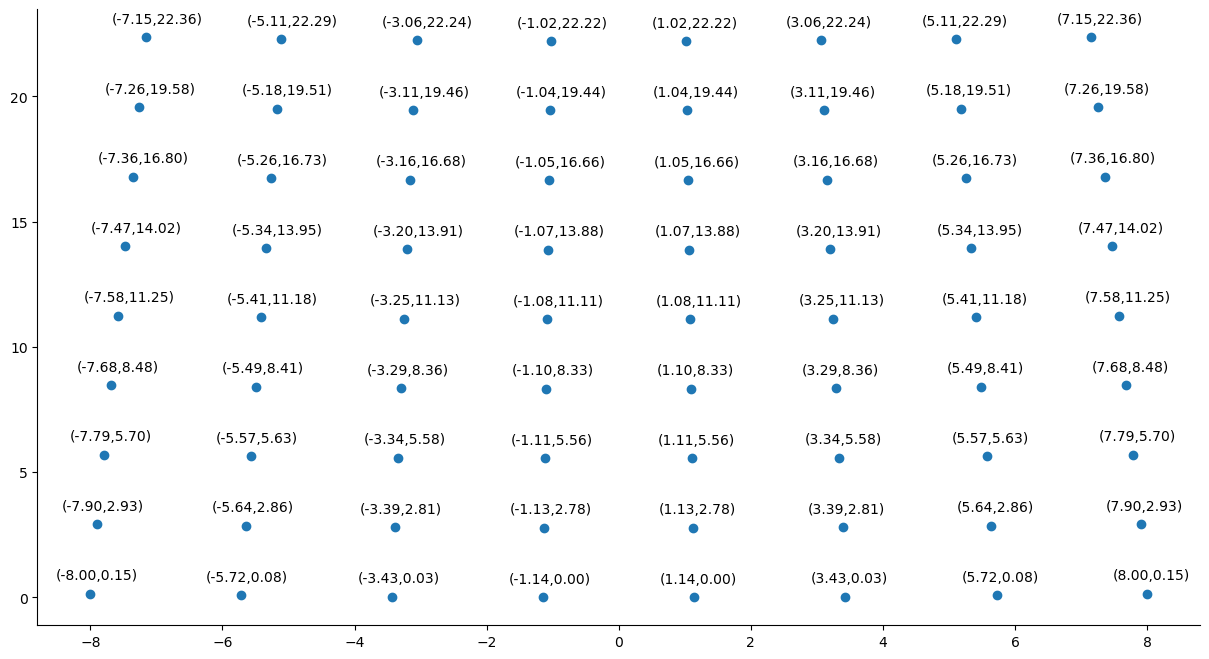

In [23]:
#绘图
#设置画布大小
plt.figure(figsize=(15,8))
#散点图
plt.scatter(res_x2,res_y2)
#坐标显示
for xy in zip(res_x2,res_y2):
     plt.annotate("(%.2f,%.2f)" % xy, xy=xy, xytext=(-25, 10), textcoords='offset points')
sns.despine()
plt.show()